In [6]:
import os

from google.colab import drive
drive.mount('/content/drive')

base_dir="/content/drive/MyDrive/"

train_dir = os.path.join(base_dir, "train.zip")
test_dir = os.path.join(base_dir, "test1.zip")

import zipfile

with zipfile.ZipFile(train_dir,"r") as z:

    z.extractall()

with zipfile.ZipFile(test_dir,"r") as z:

    z.extractall()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

'''setting seed'''
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# specifying dataset directories
train_dir = "/content/train"
test_dir = "/content/test1"

print('number of training images - ',len(os.listdir(train_dir)))
print('number of testing images - ',len(os.listdir(test_dir)))

number of training images -  25000
number of testing images -  12500


In [10]:
file_names = os.listdir(train_dir)
print('There are {} number of images in directory.'.format(len(file_names)))

There are 25000 number of images in directory.


In [11]:
def to_dataframe(file_names):
    files, labels = list(), list()
    for file in file_names:
        files.append(file)
        labels.append(file[:3])
    df = pd.DataFrame({'filename':files, 'label':labels})
    return df

df = to_dataframe(file_names)

In [12]:
df.head()

,filename,label
0,cat.11580.jpg,cat
1,dog.7796.jpg,dog
2,cat.759.jpg,cat
3,dog.6413.jpg,dog
4,dog.3618.jpg,dog


data set label distribution:
 cat    12500
dog    12500
Name: label, dtype: int64


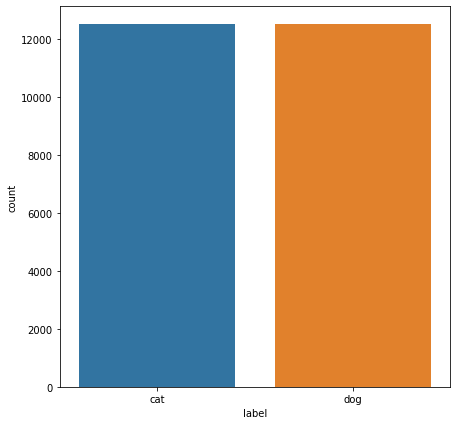

In [13]:
print('data set label distribution:\n',df['label'].value_counts())

plt.figure(figsize=(7,7))
sns.countplot(x = df['label'])
plt.show()


In [14]:
cat = [file for file in file_names if file[:3]=='cat']
dog = [file for file in file_names if file[:3]=='dog']

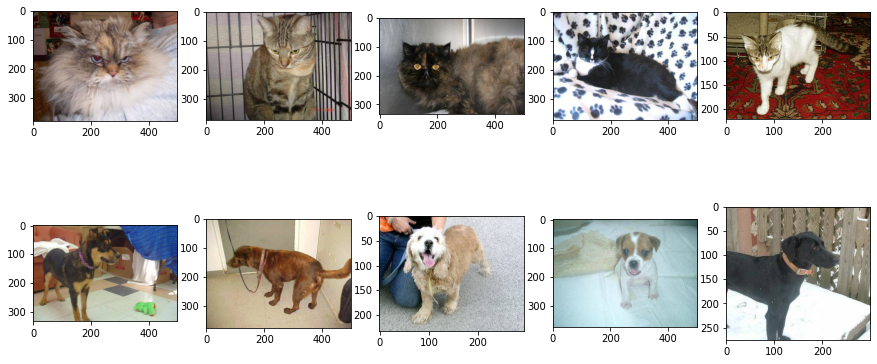

In [15]:
plt.figure(figsize=(15,7))
for i, c in enumerate(np.random.randint(0,len(cat),5), start=1):
    im = img.imread('./train/'+cat[c])
    plt.subplot(2,5,i)
    plt.imshow(im)
    
for i, c in enumerate(np.random.randint(0,len(dog),5), start=6):
    im = img.imread('./train/'+dog[c])
    plt.subplot(2,5,i)
    plt.imshow(im)

In [16]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(df, test_size=0.2,random_state=seed)

In [17]:
train_set.shape, valid_set.shape

((20000, 2), (5000, 2))

train set distribution:
 cat    10047
dog     9953
Name: label, dtype: int64

valid set distribution:
 dog    2547
cat    2453
Name: label, dtype: int64



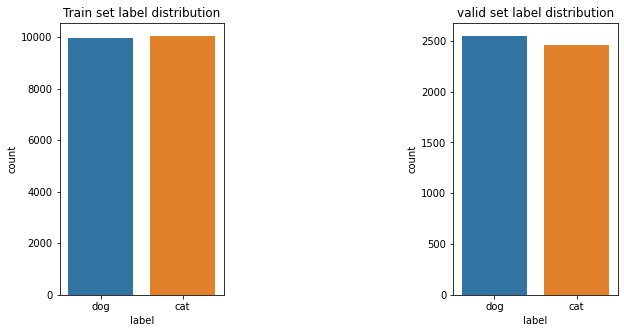

In [18]:
print('train set distribution:\n',train_set['label'].value_counts())
print('\nvalid set distribution:\n',valid_set['label'].value_counts())
print()

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.countplot(x=train_set['label'], order=['dog','cat'])
plt.title('Train set label distribution')

plt.subplot(1,3,3)
sns.countplot(x=valid_set['label'], order=['dog','cat'])
plt.title('valid set label distribution')
plt.show()

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

WIDTH, HEIGHT = 150, 150
batch_size = 32

In [20]:
train_datagenerator = ImageDataGenerator(rotation_range=15, 
                                  rescale=1./255, 
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

training_data = train_datagenerator.flow_from_dataframe(dataframe=train_set, 
                                                        directory='./train',
                                                       x_col='filename',
                                                       y_col='label',
                                                       target_size=(WIDTH, HEIGHT),
                                                       class_mode='categorical',
                                                       batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [21]:
valid_datagenerator = ImageDataGenerator(rescale=1./255)
validation_data = valid_datagenerator.flow_from_dataframe(dataframe=valid_set,
                                                         directory='./train',
                                                         x_col='filename',
                                                         y_col='label',
                                                         target_size=(WIDTH,HEIGHT),
                                                         class_mode='categorical',
                                                         batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [22]:
from tensorflow.keras.layers import *
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential()

model.add(DefaultConv2D(filters=32, kernel_size=5, input_shape=(WIDTH, HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(DefaultConv2D(filters=64))
model.add(DefaultConv2D(filters=64))
model.add(MaxPooling2D(pool_size=2))

model.add(DefaultConv2D(filters=128))
model.add(DefaultConv2D(filters=128))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 128)       7

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', min_lr=0.00001)
checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

callbacks = [earlystop_cb, reduce_lr_cb, checkpoint_cb]

In [24]:
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])


In [25]:
history = model.fit(training_data,
                   epochs=50,
                   validation_data=validation_data,
                   validation_steps=valid_set.shape[0]//batch_size,
                   steps_per_epoch=train_set.shape[0]//batch_size, 
                   callbacks=callbacks)

Epoch 1/50
625/625 [==============================] - 180s 273ms/step - loss: 0.6930 - accuracy: 0.5124 - val_loss: 0.6888 - val_accuracy: 0.5581 - lr: 0.0100
Epoch 2/50
625/625 [==============================] - 174s 278ms/step - loss: 0.6822 - accuracy: 0.5631 - val_loss: 0.6752 - val_accuracy: 0.5769 - lr: 0.0100
Epoch 3/50
625/625 [==============================] - 173s 276ms/step - loss: 0.6566 - accuracy: 0.6144 - val_loss: 0.6186 - val_accuracy: 0.6707 - lr: 0.0100
Epoch 4/50
625/625 [==============================] - 174s 278ms/step - loss: 0.6203 - accuracy: 0.6623 - val_loss: 0.5798 - val_accuracy: 0.7143 - lr: 0.0100
Epoch 5/50
625/625 [==============================] - 173s 277ms/step - loss: 0.5827 - accuracy: 0.6959 - val_loss: 0.5196 - val_accuracy: 0.7374 - lr: 0.0100
Epoch 6/50
625/625 [==============================] - 166s 265ms/step - loss: 0.5406 - accuracy: 0.7304 - val_loss: 0.4726 - val_accuracy: 0.7728 - lr: 0.0100
Epoch 7/50
625/625 [==========================

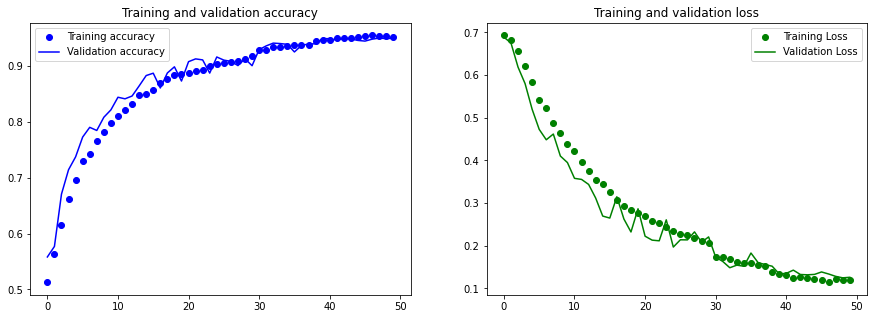

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
model1 = keras.models.load_model('model.h5')

In [28]:
test_loss, test_acc = model1.evaluate(validation_data, steps=len(validation_data), verbose=1)
print('Loss: %.3f' % (test_loss))
print('Accuracy: %.3f' % (test_acc * 100.0)) 


157/157 [==============================] - 15s 96ms/step - loss: 0.1244 - accuracy: 0.9492
Loss: 0.124
Accuracy: 94.920


In [30]:
sampleSubmission = pd.read_csv('/content/sampleSubmission.csv')
test_df = sampleSubmission.copy()
test_df['id'] = test_df['id'].apply(lambda x : str(x)+'.jpg')

In [31]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(test_df, 
                                                "./test1/", 
                                                x_col='id',
                                                y_col=None,
                                                class_mode=None,
                                                target_size=(WIDTH,HEIGHT),
                                                batch_size=batch_size,
                                                shuffle=False)

Found 12500 validated image filenames.


In [32]:
predict = model1.predict(test_generator, steps=np.ceil(test_df.shape[0]/batch_size))

391/391 [==============================] - 39s 99ms/step


In [33]:
sampleSubmission['label'] = np.argmax(predict, axis=-1)
sampleSubmission.to_csv('submission.csv', index=False)

In [34]:
test_df['label'] = sampleSubmission['label'].replace({ 1: 'dog', 0: 'cat' })

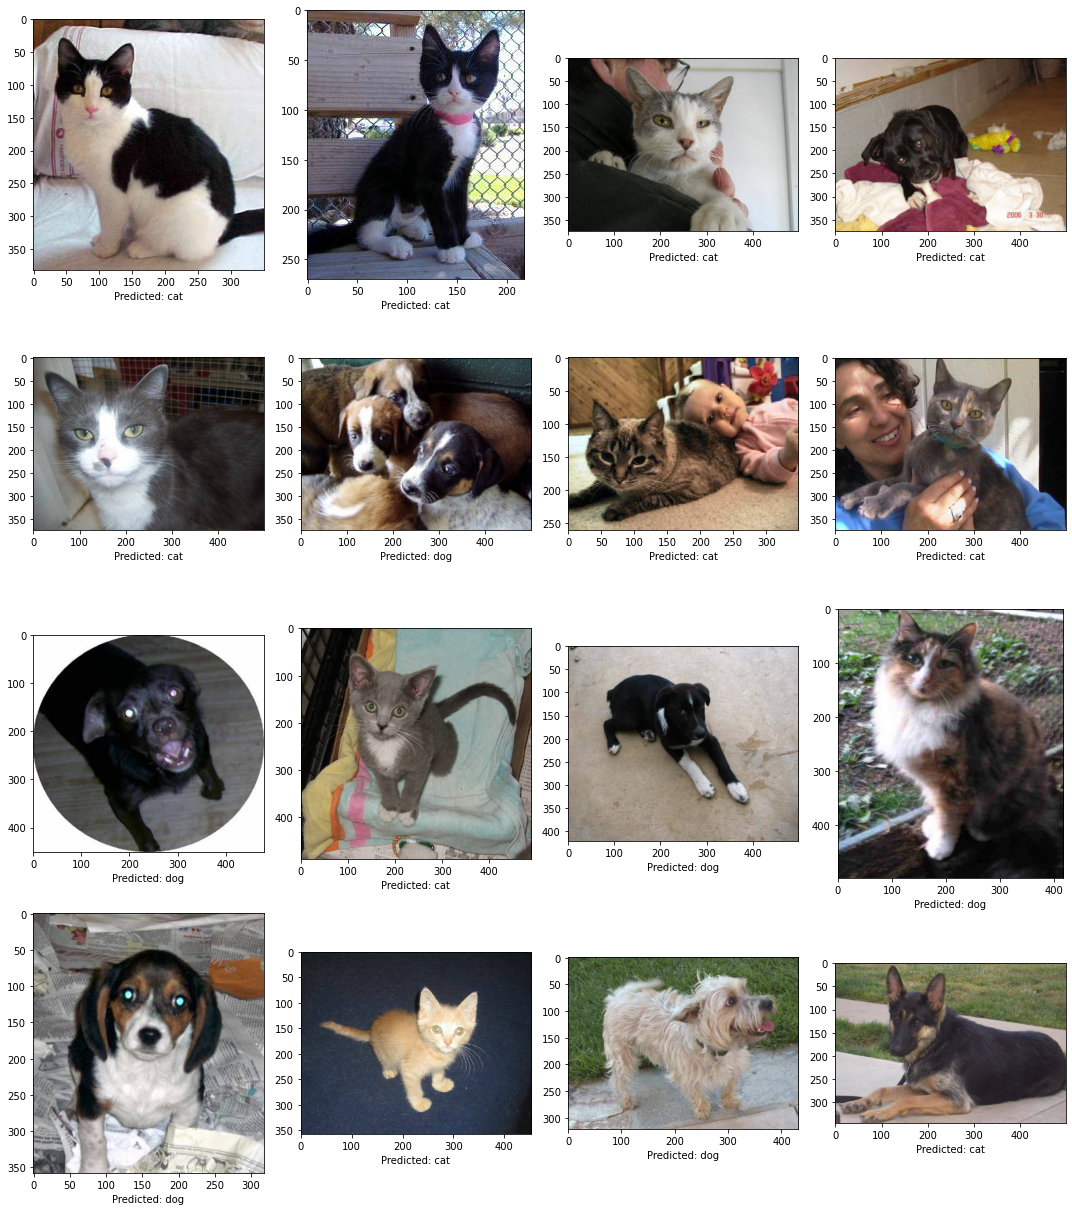

In [35]:
sample_test = test_df.values[np.random.randint(0, len(test_df), 16)]
sample_test
plt.figure(figsize=(15, 17))
for index, row in enumerate(sample_test):
    filename = row[0]
    category = row[1]
    image = img.imread("./test1/"+filename)
    plt.subplot(4, 4, index+1)
    plt.imshow(image)
    plt.xlabel('Predicted: ' + "{}".format(category) )
plt.tight_layout()
plt.show()